# 'Investigate my Gospels'

Task: Provide unforeseen insights of New Testament Gospels of Matthew, Mark, Luke, and John


<img src="https://img.freepik.com/premium-photo/watercolour-jesus-christ-looking-one-side-with-lost-sad-look-generated-ai_501669-25812.jpg?w=2000" alt="Jesus Christ">

## Install modules

In [9]:
pip install pythonbible

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import nltk
import string
import pythonbible as bible
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from collections import Counter
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from transformers import pipeline
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Create data

In [13]:
# Build dataframe
gospels = [bible.Book.MATTHEW, bible.Book.MARK, bible.Book.LUKE, bible.Book.JOHN]
df = pd.DataFrame(columns=['Book', 'Chapter', 'Verse', 'Text'])

for gospel in gospels:
  for chapter in range(1, bible.get_number_of_chapters(gospel)+1):
    for verse in range(1, bible.get_number_of_verses(gospel, chapter)+1):
      df.loc[len(df.index)] = [gospel.name, chapter, verse, bible.get_verse_text(bible.get_verse_id(gospel, chapter, verse))]

In [ ]:
df.head()

,Book,Chapter,Verse,Text
0,MATTHEW,1,1,"The book of the generation of Jesus Christ, th..."
1,MATTHEW,1,2,Abraham begat Isaac; and Isaac begat Jacob; an...
2,MATTHEW,1,3,And Judas begat Phares and Zara of Thamar; and...
3,MATTHEW,1,4,And Aram begat Aminadab; and Aminadab begat Na...
4,MATTHEW,1,5,And Salmon begat Booz of Rachab; and Booz bega...


### Verse text tool
Returns text of given verses from specified chapter and book

In [36]:
def get_verse_text(book, chapter, verse_start, verse_end):
  df_new = df[(df['Book'] == book) & (df['Chapter'] == chapter) & (df['Verse'] >= verse_start) & (df['Verse'] <= verse_end)]
  return " ".join(i for i in df_new.Text.tolist())

In [38]:
title = input("Enter book: ")
chapter = int(input("Enter chapter: "))
verse_start = int(input("Enter verse start: "))
verse_end = int(input("Enter verse end: "))

get_verse_text(title.upper(), chapter, verse_start, verse_end)

Enter book: mark
Enter chapter: 9
Enter verse start: 46
Enter verse end: 50


'Where their worm dieth not, and the fire is not quenched. And if thine eye offend thee, pluck it out: it is better for thee to enter into the kingdom of God with one eye, than having two eyes to be cast into hell fire: Where their worm dieth not, and the fire is not quenched. For every one shall be salted with fire, and every sacrifice shall be salted with salt. Salt is good: but if the salt have lost his saltness, wherewith will ye season it? Have salt in yourselves, and have peace one with another.'

### Bible search tool
Returns instances of given text from specified verse, chapter, and book

In [ ]:
def search(book, chapter, verse, text):
  def get_verse():
    if verse == 'any': return True
    else: return df['Verse'] == int(verse)

  def get_chapter():
    if chapter == 'any': return True
    else: return df['Chapter'] == int(chapter)

  def get_book():
    if book.lower() == 'any': return True
    else: return df['Book'] == book

  return df.loc[(df['Text'].str.contains(text, case=False)) & (get_verse()) & (get_chapter()) & (get_book())]

In [ ]:
title = input("Enter book (type 'any' for all): ")
chapter = input("Enter chapter (type 'any' for all): ")
verse = input("Enter verse (type 'any' for all): ")
text = input("Enter text: ")

search(title.upper(), chapter, verse, text)

Enter book (type 'any' for all): any
Enter chapter (type 'any' for all): any
Enter verse (type 'any' for all): any
Enter text: lamp


,Book,Chapter,Verse,Text
864,MATTHEW,25,1,Then shall the kingdom of heaven be likened un...
866,MATTHEW,25,3,"They that were foolish took their lamps, and t..."
867,MATTHEW,25,4,But the wise took oil in their vessels with th...
870,MATTHEW,25,7,"Then all those virgins arose, and trimmed thei..."
871,MATTHEW,25,8,"And the foolish said unto the wise, Give us of..."


## Data analysis

### Find most frequent words

In [ ]:
# Function to preprocess text
def prepare_text(text):
  # Turn all text lowercase
  freq_words = text.str.lower()
  # Remove punctuation
  freq_words = freq_words.str.replace(r'[^\w\s]+', '')
  # Delete all common English words
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.extend(['unto', 'shall', 'said', 'ye', 'thou', 'came', 'come', 'saying', 'say', 'thee', 'thy', 'went', 'hath', 'saith', 'also', 'let', 'spake', 'thing', 'things', 'answered', 'therefore'])
  return freq_words.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#### In all gospels

In [ ]:
# List of top 10 most frequent words
freq_words = prepare_text(df['Text'])
most_common = Counter(" ".join(freq_words).split()).most_common(10)
most_common

<ipython-input-8-1e77a58fc73c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  freq_words = freq_words.str.replace(r'[^\w\s]+', '')


[('jesus', 625),
 ('man', 468),
 ('son', 324),
 ('god', 312),
 ('one', 278),
 ('father', 248),
 ('lord', 244),
 ('disciples', 217),
 ('go', 177),
 ('day', 164)]

[Text(0.5, 1.0, 'All Gospels')]

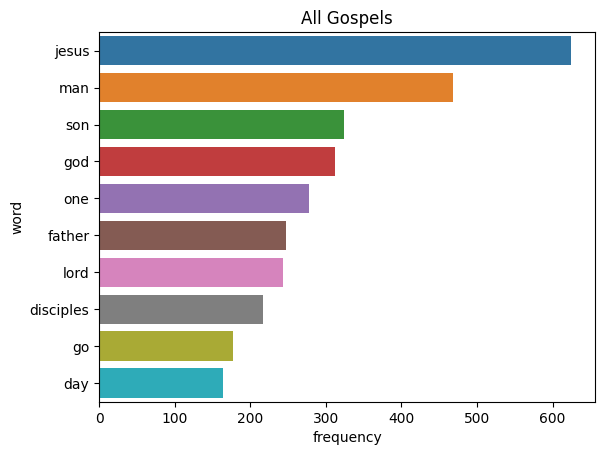

In [ ]:
# Bar plot of top 10 most frequent words
sns.barplot(x='frequency', y='word', data=pd.DataFrame(most_common, columns=['word', 'frequency'])).set(title='All Gospels')

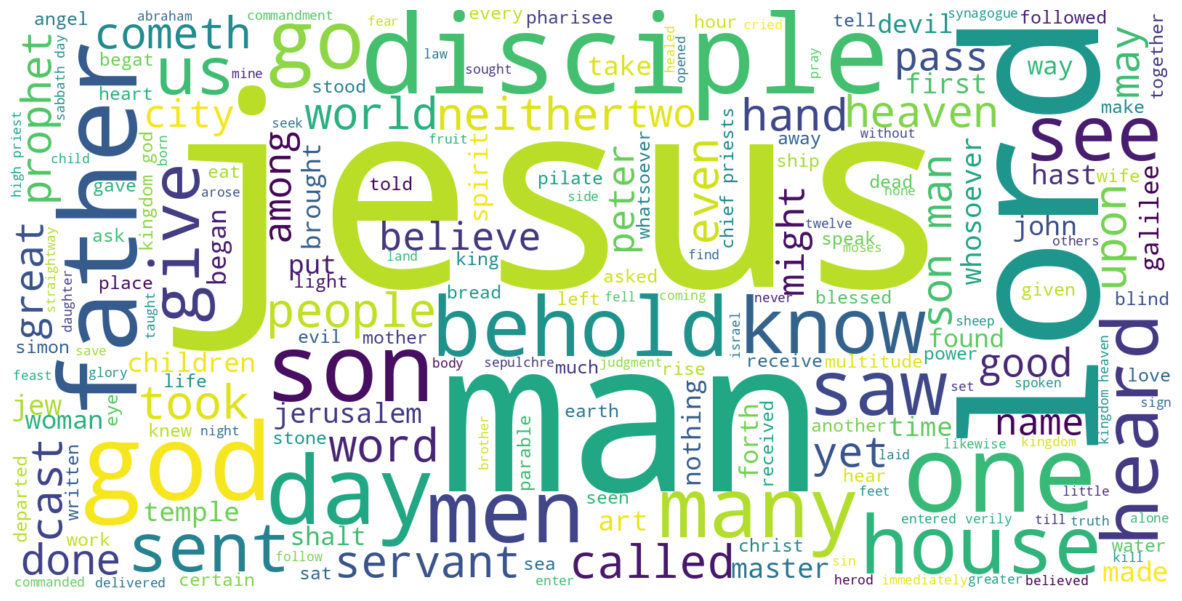

In [ ]:
# Word Cloud model of most frequent words
text = " ".join(i for i in freq_words)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### By each gospel

In [ ]:
matthew = Counter(" ".join(prepare_text(df.loc[df['Book'] == 'MATTHEW'].Text)).split()).most_common(10)
mark = Counter(" ".join(prepare_text(df.loc[df['Book'] == 'MARK'].Text)).split()).most_common(10)
luke = Counter(" ".join(prepare_text(df.loc[df['Book'] == 'LUKE'].Text)).split()).most_common(10)
john = Counter(" ".join(prepare_text(df.loc[df['Book'] == 'JOHN'].Text)).split()).most_common(10)

<ipython-input-8-1e77a58fc73c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  freq_words = freq_words.str.replace(r'[^\w\s]+', '')


[Text(0.5, 1.0, 'John')]

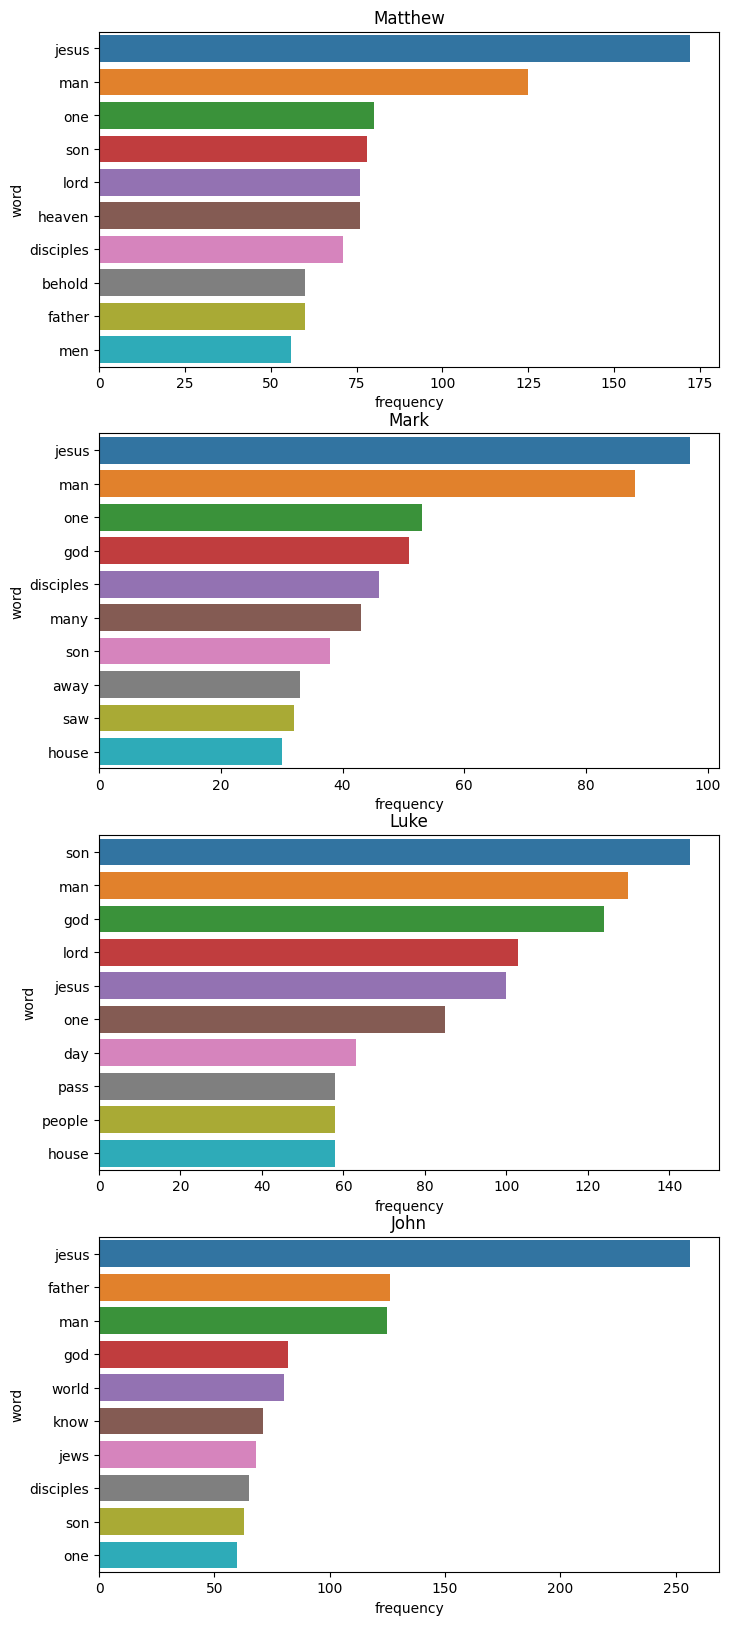

In [ ]:
# Subplot of top 10 most common terms for each gospel
fig, axes = plt.subplots(4,1,figsize=(8,20))
sns.barplot(ax=axes[0], x='frequency', y='word', data=pd.DataFrame(matthew, columns=['word', 'frequency'])).set(title='Matthew')
sns.barplot(ax=axes[1], x='frequency', y='word', data=pd.DataFrame(mark, columns=['word', 'frequency'])).set(title='Mark')
sns.barplot(ax=axes[2], x='frequency', y='word', data=pd.DataFrame(luke, columns=['word', 'frequency'])).set(title='Luke')
sns.barplot(ax=axes[3], x='frequency', y='word', data=pd.DataFrame(john, columns=['word', 'frequency'])).set(title='John')

### Find most frequent numbers

In [ ]:
# Create array of wordified numbers
nums = [num2words(i) for i in range(1, 10000)]

In [ ]:
freq_words = prepare_text(df['Text'])
most_common = Counter(" ".join(freq_words).split()).most_common(1000)
for item in most_common[:]:
  if not item[0] in nums:
    most_common.remove(item)

<ipython-input-8-1e77a58fc73c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  freq_words = freq_words.str.replace(r'[^\w\s]+', '')


[('one', 278),
 ('two', 96),
 ('twelve', 46),
 ('five', 36),
 ('three', 33),
 ('seven', 27),
 ('ten', 15),
 ('four', 12),
 ('thirty', 8),
 ('six', 7),
 ('forty', 5)]

[Text(0.5, 1.0, 'All Gospels')]

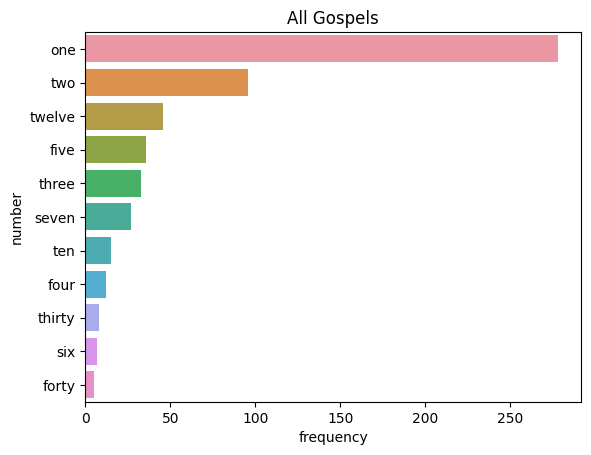

In [ ]:
# Bar plot of top 11 most frequent numbers
sns.barplot(x='frequency', y='number', data=pd.DataFrame(most_common, columns=['number', 'frequency'])).set(title='All Gospels')

### Find most frequent names

In [ ]:
# Extract names from text
text = " ".join(i for i in df.Text.tolist())
names = list()

nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
for nltk_result in nltk_results:
    if type(nltk_result) == Tree:
        name = ''
        for nltk_result_leaf in nltk_result.leaves():
            name += nltk_result_leaf[0] + ' '
        names.append({'Type': nltk_result.label(), 'Name': name})

[Text(0.5, 1.0, 'Top 10 Most Common Names in the Gospels')]

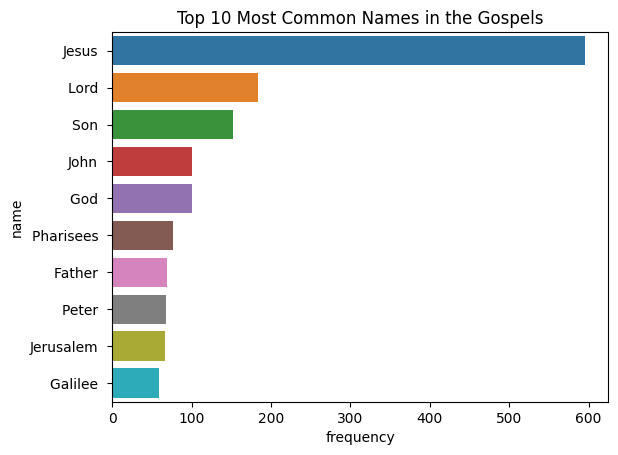

In [ ]:
# Bar plot of top 10 most frequent names
sns.barplot(x='frequency', y='name', data=pd.DataFrame(Counter(i['Name'] for i in names).most_common(10), columns=['name', 'frequency'])).set(title='Top 10 Most Common Names in the Gospels')

### Find most frequent commands

### Sentiment analysis

In [14]:
# Create pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


#### Verse classification tool
Returns whether input verse has emotionally 'positive' or 'negative' text

In [39]:
# Function to classify verses
def classify_verse(book, chapter, verse_start, verse_end): return classifier(get_verse_text(book, chapter, verse_start, verse_end))

In [43]:
# Classify by book, chapter, and verse
title = input("Enter book: ")
chapter = int(input("Enter chapter: "))
verse_start = int(input("Enter verse start: "))
verse_end = int(input("Enter verse end: "))

classify_verse(title.upper(), chapter, verse_start, verse_end)

Enter book: luke
Enter chapter: 12
Enter verse start: 43
Enter verse end: 43


[{'label': 'POSITIVE', 'score': 0.9992926120758057}]

#### Book/chapter analysis

In [47]:
# Create new columns of sentiment values and scores
df_sent = df.copy()
df_sent['Sentiment'] = ''
df_sent['Sent_Score'] = ''

for x in df_sent.Text.tolist():
  result = classifier(x)[0]
  index = df_sent.Text.tolist().index(x)
  df_sent.at[index, 'Sentiment'] = result['label']
  df_sent.at[index, 'Sent_Score'] = result['score']

df_sent.head()

,Book,Chapter,Verse,Text,Sentiment,Sent_Score
0,MATTHEW,1,1,"The book of the generation of Jesus Christ, th...",POSITIVE,0.996187
1,MATTHEW,1,2,Abraham begat Isaac; and Isaac begat Jacob; an...,NEGATIVE,0.99099
2,MATTHEW,1,3,And Judas begat Phares and Zara of Thamar; and...,NEGATIVE,0.993137
3,MATTHEW,1,4,And Aram begat Aminadab; and Aminadab begat Na...,NEGATIVE,0.961483
4,MATTHEW,1,5,And Salmon begat Booz of Rachab; and Booz bega...,NEGATIVE,0.992164


In [56]:
# Strangely there are 12 verses that cannot be classified and are blank, we will drop these
df_sent = df_sent.loc[df_sent['Sent_Score']!='']

In [60]:
# Create function to return sum of sentiments for each chapter
def sent_sum(book):
  df = df_sent.loc[df_sent['Book'] == book].groupby(['Chapter'])['Sentiment'].describe().reset_index()
  df['ratio'] = df['freq']/df['count']
  df.index=[x for x in range (len(df)*2) if x%2!=0]
  for x in range (2,(len(df)*2)+2):
    if x%2==0:
      def get_top():
        if df.loc[x-1].top == 'POSITIVE': return 'NEGATIVE'
        else: return 'POSITIVE'
      df.loc[x]=[df.loc[x-1].Chapter, 0, 0, get_top(), 0, 1 - df.loc[x-1].ratio]
  df=df.sort_index()
  return df

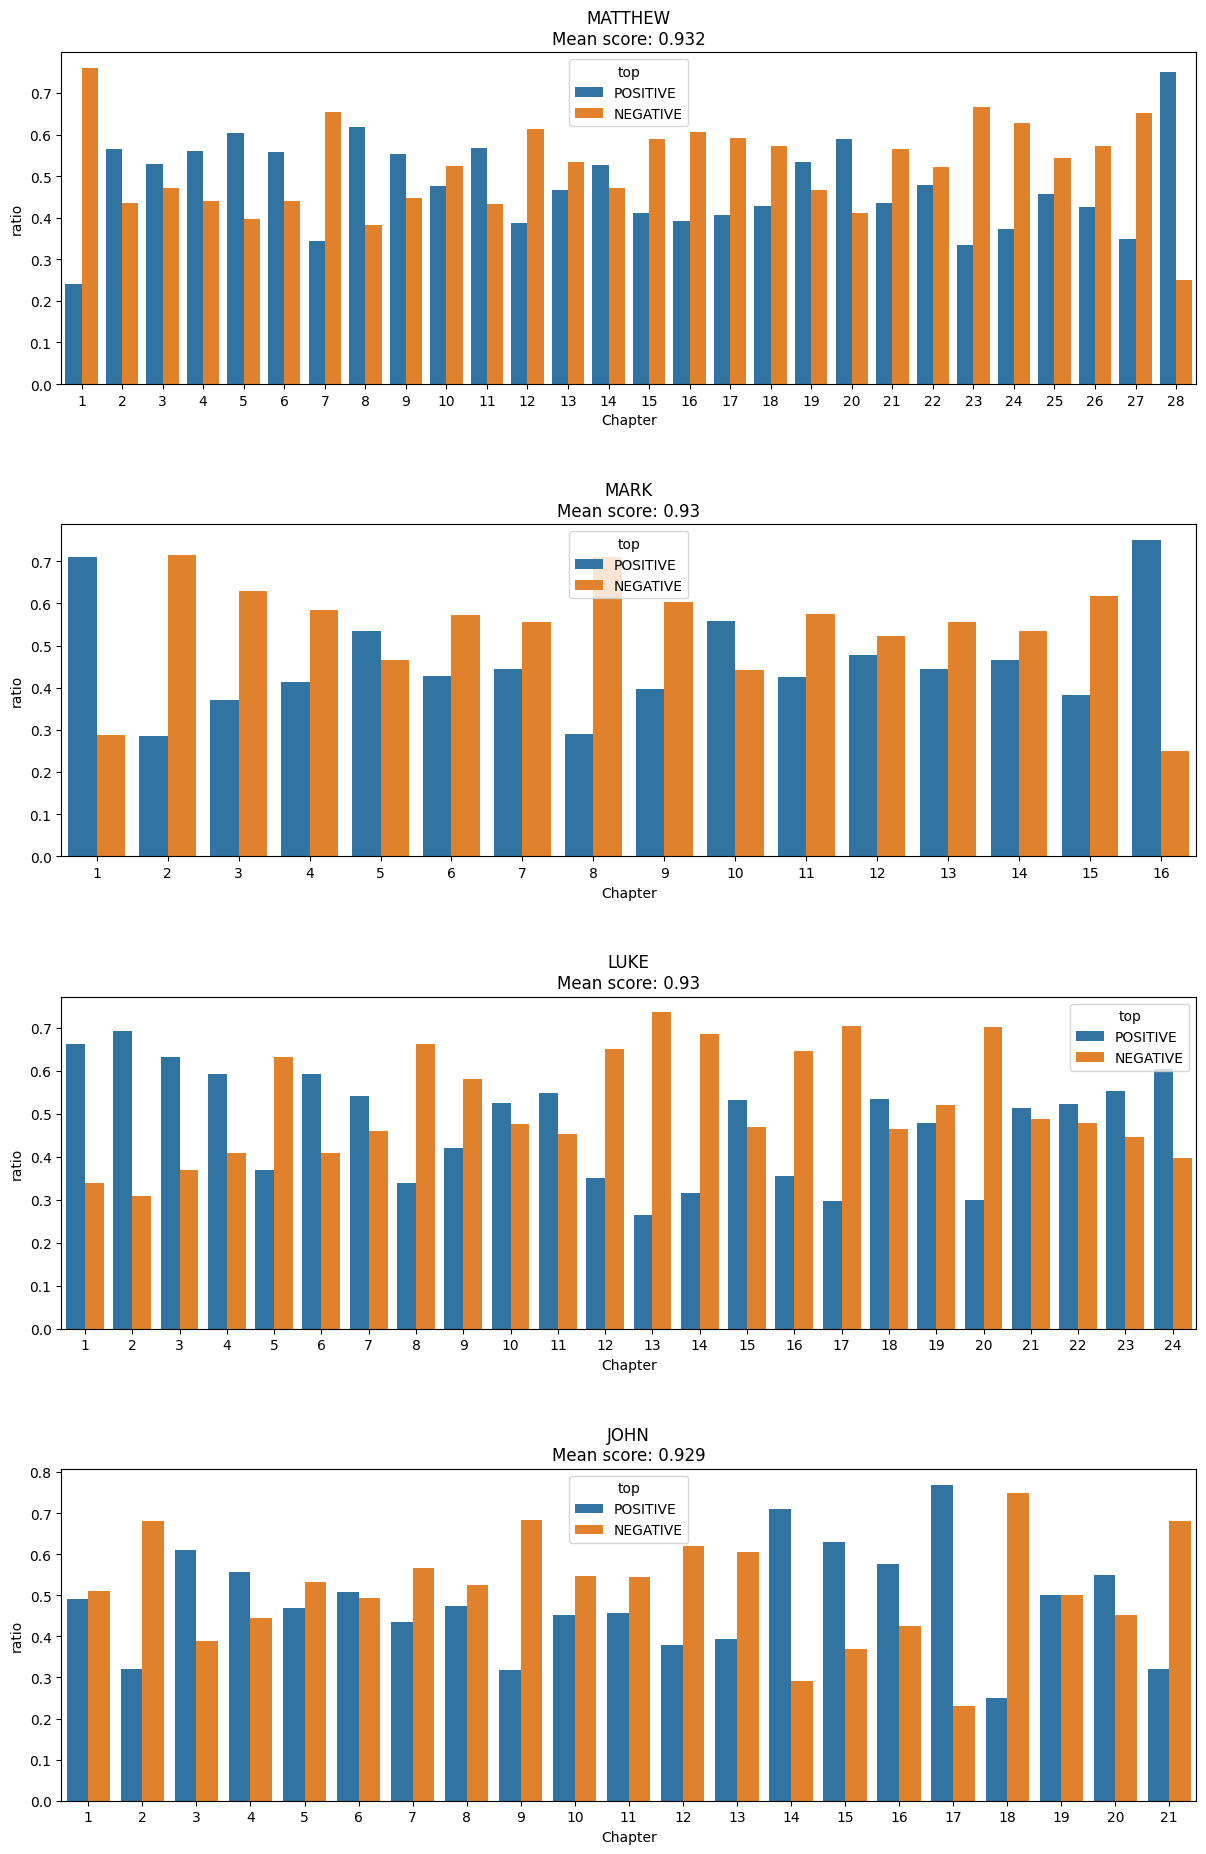

In [76]:
# Plot ratio of sentiment sums for each chapter of each gospel
fig, axes = plt.subplots(4,1,figsize=(14,20))
fig.tight_layout(pad=8.0)

for gospel in gospels:
  df_bp = sent_sum(gospel.name)
  bp = sns.barplot(ax=axes[gospels.index(gospel)],
              data=df_bp,
              x='Chapter',
              y='ratio',
              hue='top',
              hue_order=['POSITIVE', 'NEGATIVE'])
  bp.set_title(gospel.name + '\nMean score: ' + str(round(df_sent.loc[df_sent['Book'] == gospel.name]['Sent_Score'].mean(), 3)))

## Data prediction

### Verse recommendation tool
Returns top 10 most similar verses to input verse

In [ ]:
# Apply tfidf vectorizer to dataframe
tfidf_wm = TfidfVectorizer(analyzer='word', stop_words='english').fit_transform(df.Text)

In [ ]:
# Create a cosine similarity model
cosine_sim = cosine_similarity(tfidf_wm, tfidf_wm)

In [ ]:
# Create function to recommend verses
def get_verse_recommendations(book, chapter, verse):
  idx = df[(df['Book'] == book) & (df['Chapter'] == chapter) & (df['Verse'] == verse)].index[0]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  verse_indices = [i[0] for i in sim_scores]
  df_rec = df.iloc[verse_indices].tail(-1)
  df_rec['Sim_Score'] = pd.Series([i[1] for i in sim_scores], index=verse_indices)
  print('\nBased on: ' + book +  ' ' + str(chapter) + ':' + str(verse) + '\n')
  return df_rec.head(10)

In [ ]:
title = input("Enter book: ")
chapter = int(input("Enter chapter: "))
verse = int(input("Enter verse: "))

get_verse_recommendations(title.upper(), chapter, verse)

Enter book: matthew
Enter chapter: 1
Enter verse: 1

Based on: MATTHEW 1:1



,Book,Chapter,Verse,Text,Sim_Score
2675,LUKE,20,41,"And he said unto them, How say they that Chris...",0.567613
769,MATTHEW,22,42,"Saying, What think ye of Christ? whose son is ...",0.530867
772,MATTHEW,22,45,"If David then call him Lord, how is he his son?",0.496239
1914,LUKE,3,34,"Which was the son of Jacob, which was the son ...",0.446181
1563,MARK,12,35,"And Jesus answered and said, while he taught i...",0.427249
1911,LUKE,3,31,"Which was the son of Melea, which was the son ...",0.425152
2678,LUKE,20,44,"David therefore calleth him Lord, how is he th...",0.374375
2581,LUKE,18,38,"And he cried, saying, Jesus, thou Son of David...",0.364072
367,MATTHEW,12,23,"And all the people were amazed, and said, Is n...",0.358529
1910,LUKE,3,30,"Which was the son of Simeon, which was the son...",0.354925


### Question answering tool
Answers provided question given input biblical verse context

In [ ]:
# Create pipeline
qa_model = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# Create function to answer question given context
def answer_question(book, chapter, verse_start, verse_end, question): return qa_model(question = question, context = get_verse_text(book, chapter, verse_start, verse_end))

In [ ]:
# Answer question given verse context
title = input("Enter book: ")
chapter = int(input("Enter chapter: "))
verse_start = int(input("Enter verse start: "))
verse_end = int(input("Enter verse end: "))
question = input('Enter question: ')

answer_question(title.upper(), chapter, verse_start, verse_end, question)

Enter book: luke
Enter chapter: 1
Enter verse start: 26
Enter verse end: 38
Enter question: who is jesus


{'score': 0.8464207053184509, 'start': 1296, 'end': 1302, 'answer': 'barren'}